# jr-yr-stats: Exploratory Data Analysis (EDA)

Situational Analysis
Look for patterns in different contexts:
Home vs away? (need to add location if you have it)
Tournaments vs regular games: performance shift?
Duplicate matchups same day — how did your stats change?

Best & Worst Games
Find peak and valleys:
Match with highest points, kills, or hit_pct
Lowest serve_pct or most serve_err

Correlation Insights
What influences success?
Does higher aces_per_set correlate with wins?
What’s most predictive of numeric_result?

Custom Metrics
Make your own:
Efficiency = kills - errors / attempts
Serve effectiveness = aces - serve_err
Or composite “impact score” based on weighted stats

In [74]:
# module imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
# import data
df = pd.read_csv('../data/cleaned/all_seasons.csv')

### Descriptive Statistics

In [76]:
# total matches played (2016, 2017, 2019)
print("Raw counts -", df.shape[0], "games\n", df['result'].value_counts())
print("\nNormalized -", df.shape[0], "games\n", round(df['result'].value_counts(normalize=True), 2))

Raw counts - 112 games
 result
W    69
L    42
T     1
Name: count, dtype: int64

Normalized - 112 games
 result
W    0.62
L    0.38
T    0.01
Name: proportion, dtype: float64


I won 62% of the matches I played in 2016, 2017, and 2019. 

In [77]:
# average set difference & margin
print("Set difference:", round(df['set_diff'].mean(), 2))
print("Margin:", round(df['margin_pct'].mean(), 2), "%")

Set difference: 0.79
Margin: 0.26 %


Looking at the average difference in sets won vs sets lost per match. 
- Won 3–0, set difference = +3
- Lost 2–3, set difference = –1
- Won 2–1, set difference = +1
- Lost 0–2, set difference = –2

My average of 0.79 means that I won just under 1 more set than I lost per match (yay positive!). As for the margin (% of sets played per match, calculated as `margin_pct = set_diff / set_count`), I was winning matches with a moderate but consistent edge in set counts. 

In [78]:
# describe DF
print(round(df.describe(), 2))

       match_number  match_index  season_year  set_diff  set_count  \
count        112.00       112.00       112.00    112.00     112.00   
mean           1.66        19.56      2017.50      0.79       2.82   
std            1.10        11.53         1.29      2.29       0.66   
min            1.00         1.00      2016.00     -3.00       2.00   
25%            1.00        10.00      2016.00     -2.00       2.00   
50%            1.00        19.00      2017.00      2.00       3.00   
75%            2.00        28.25      2019.00      3.00       3.00   
max            5.00        45.00      2019.00      3.00       5.00   

       margin_pct  numeric_result  sets_played   kills  kills_per_set  ...  \
count      112.00          112.00       112.00  112.00         112.00  ...   
mean         0.26            0.24         2.77    6.57           2.38  ...   
std          0.85            0.97         0.70    3.78           1.21  ...   
min         -1.00           -1.00         1.00    1.00   

### Performance Over Time

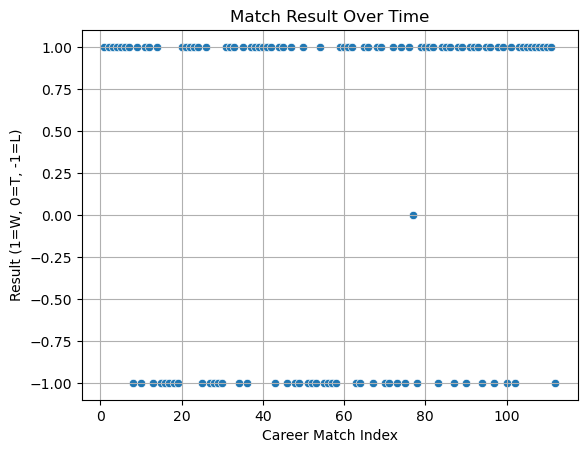

In [79]:
sns.scatterplot(data=df, x="career_match_index", y="numeric_result", marker="o")
plt.title("Match Result Over Time")
plt.ylabel("Result (1=W, 0=T, -1=L)")
plt.xlabel("Career Match Index")
plt.grid(True)
plt.show()

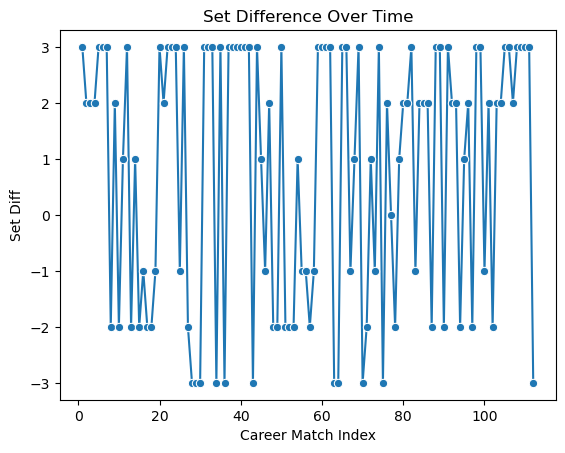

In [80]:
sns.lineplot(data=df, x="career_match_index", y="set_diff", marker="o")
plt.title("Set Difference Over Time")
plt.xlabel("Career Match Index")
plt.ylabel("Set Diff")
plt.show()

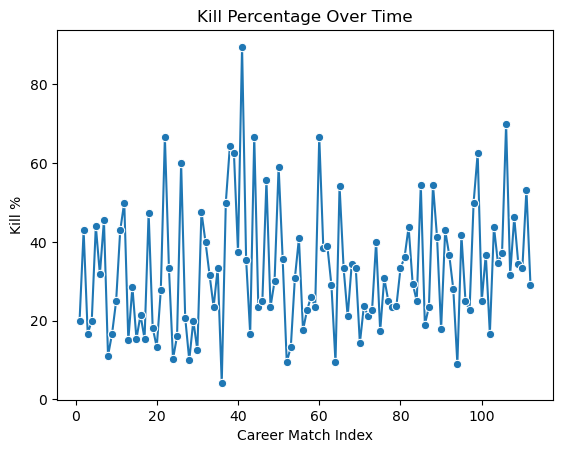

In [81]:
sns.lineplot(data=df, x="career_match_index", y="kill_pct", marker="o")
plt.title("Kill Percentage Over Time")
plt.ylabel("Kill %")
plt.xlabel("Career Match Index")
plt.show()

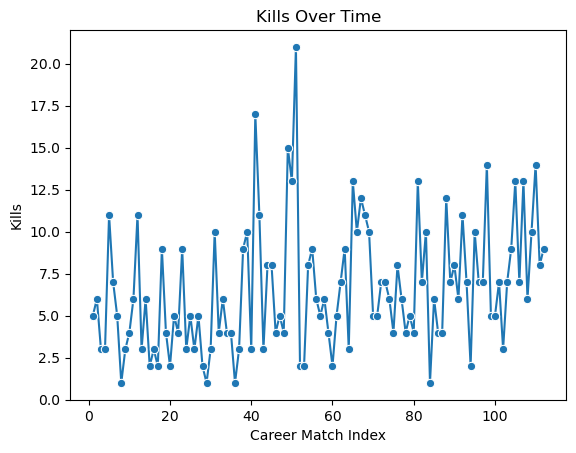

In [82]:
sns.lineplot(data=df, x="career_match_index", y="kills", marker="o")
plt.title("Kills Over Time")
plt.ylabel("Kills")
plt.xlabel("Career Match Index")
plt.show()

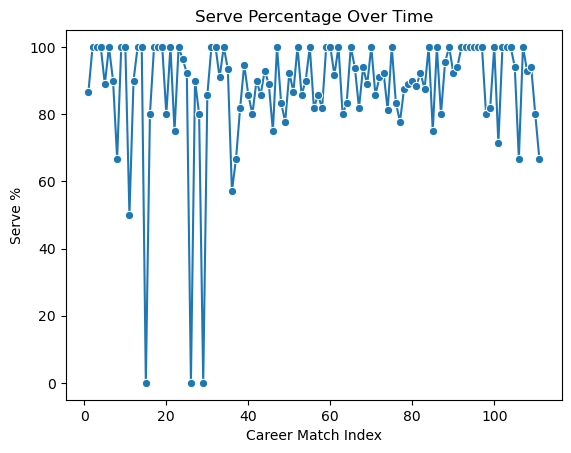

In [83]:
sns.lineplot(data=df, x="career_match_index", y="serve_pct", marker="o")
plt.title("Serve Percentage Over Time")
plt.ylabel("Serve %")
plt.xlabel("Career Match Index")
plt.show()

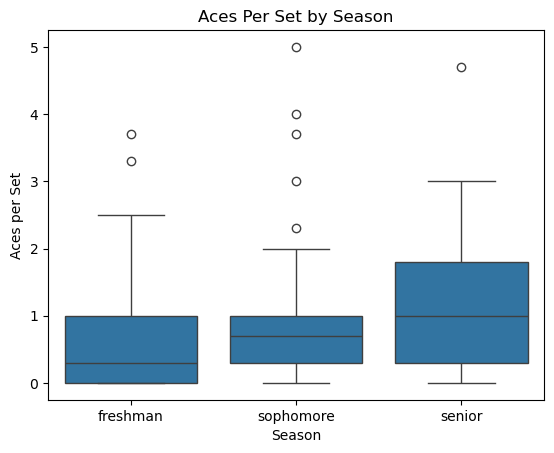

In [84]:
sns.boxplot(data=df, x="season_label", y="aces_per_set")
plt.title("Aces Per Set by Season")
plt.xlabel("Season")
plt.ylabel("Aces per Set")
plt.show()

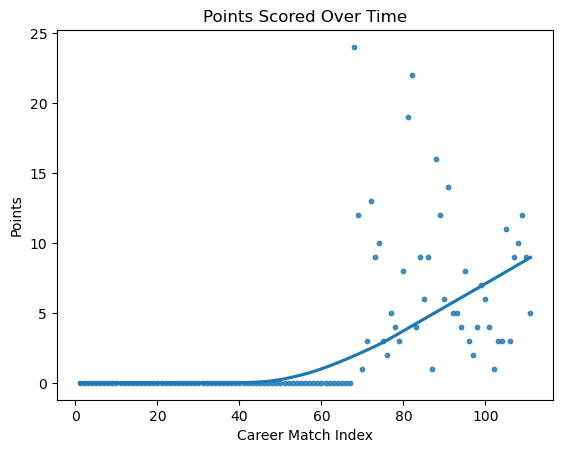

In [85]:
# only really reliable for senior year as coaches did not start tracking points until then. 
sns.regplot(data=df, x="career_match_index", y="points", lowess=True, scatter_kws={"s": 10})
plt.title("Points Scored Over Time")
plt.xlabel("Career Match Index")
plt.ylabel("Points")
plt.show()

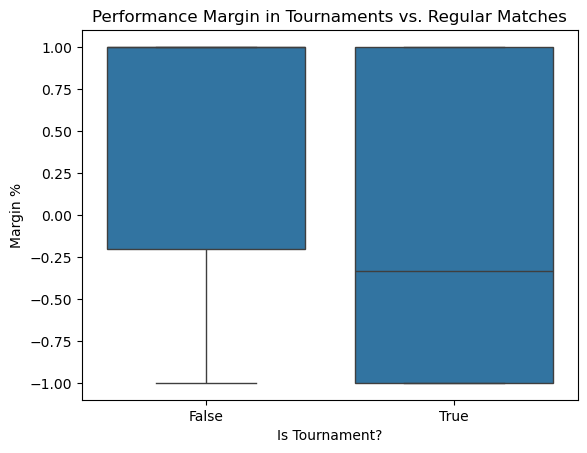

In [86]:
sns.boxplot(data=df, x="is_tournament", y="margin_pct")
plt.title("Performance Margin in Tournaments vs. Regular Matches")
plt.xlabel("Is Tournament?")
plt.ylabel("Margin %")
plt.show()

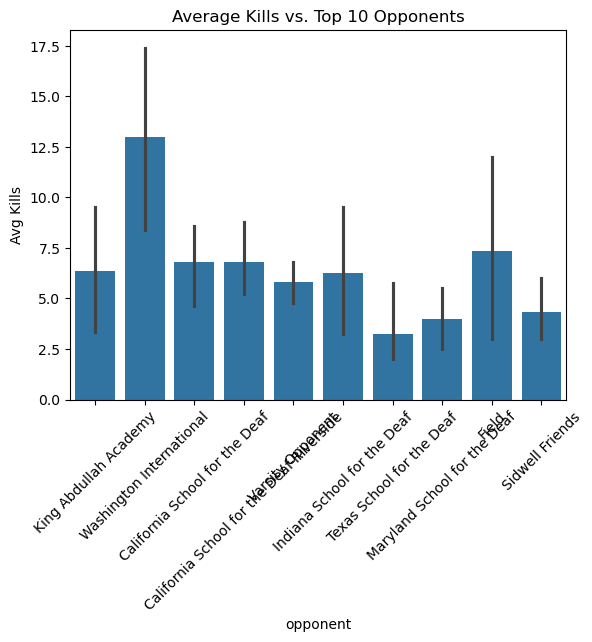

In [87]:
top_opponents = df['opponent'].value_counts().head(10).index
sns.barplot(data=df[df['opponent'].isin(top_opponents)],
            x="opponent", y="kills", estimator="mean", order=top_opponents)
plt.title("Average Kills vs. Top 10 Opponents")
plt.xticks(rotation=45)
plt.ylabel("Avg Kills")
plt.show()

### Opponents

In [88]:
df['opponent'] = df['opponent'].str.strip()

opponent_stats = df.groupby('opponent').agg(
    games_played=('result', 'count'),
    avg_set_diff=('set_diff', 'mean'),
    avg_points=('points', 'mean'),
    wins=('numeric_result', lambda x: (x == 1).sum()),
    losses=('numeric_result', lambda x: (x == -1).sum()),
    ties=('numeric_result', lambda x: (x == 0).sum())
).reset_index()

opponent_stats['win_rate'] = opponent_stats['wins'] / opponent_stats['games_played']

In [89]:
# top 5 opponents dominated (by diff)
opponent_stats.sort_values('avg_set_diff', ascending=False).head(5)

,opponent,games_played,avg_set_diff,avg_points,wins,losses,ties,win_rate
0,Alabama School for the Deaf,2,3.0,0.0,2,0,0,1.0
12,Clinton Grace Christian,1,3.0,0.0,1,0,0,1.0
33,Parkside,1,3.0,0.0,1,0,0,1.0
32,Oakcrest,2,3.0,2.0,2,0,0,1.0
30,Mississippi School for the Deaf,1,3.0,0.0,1,0,0,1.0


In [90]:
# top 5 opponents crushed by (by diff)
opponent_stats.sort_values('avg_set_diff').head(5)

,opponent,games_played,avg_set_diff,avg_points,wins,losses,ties,win_rate
44,St. John's,2,-3.000000,0.000000,0,2,0,0.0
6,Bishop O'Connell,1,-3.000000,0.000000,0,1,0,0.0
5,Bishop Ireton,3,-2.666667,2.000000,0,3,0,0.0
13,Covenant Life,3,-2.666667,0.333333,0,3,0,0.0
20,Georgetown Day,2,-2.500000,3.000000,0,2,0,0.0


In [91]:
# top 5 scored against
opponent_stats.sort_values('avg_points', ascending=False).head(5)

,opponent,games_played,avg_set_diff,avg_points,wins,losses,ties,win_rate
38,Sandy Spring Friends,2,3.0,13.0,2,0,0,1.0
22,Highland,1,1.0,13.0,1,0,0,1.0
49,Varsity Opponent,5,2.8,11.8,5,0,0,1.0
16,Episcopal,1,-1.0,9.0,0,1,0,0.0
39,School Without Walls,1,2.0,9.0,1,0,0,1.0


In [92]:
# opponents sorted by win rate
opponent_stats.sort_values('avg_points', ascending=False).head(5)

,opponent,games_played,avg_set_diff,avg_points,wins,losses,ties,win_rate
38,Sandy Spring Friends,2,3.0,13.0,2,0,0,1.0
22,Highland,1,1.0,13.0,1,0,0,1.0
49,Varsity Opponent,5,2.8,11.8,5,0,0,1.0
16,Episcopal,1,-1.0,9.0,0,1,0,0.0
39,School Without Walls,1,2.0,9.0,1,0,0,1.0


In [93]:
# opponents sorted by win rate, but only if played 3+ times
opponent_stats[opponent_stats['games_played'] >= 3].sort_values('win_rate', ascending=False)

,opponent,games_played,avg_set_diff,avg_points,wins,losses,ties,win_rate
43,Spencerville Adventist Academy,3,3.000000,3.333333,3,0,0,1.000000
50,Washington Christian Academy,3,2.666667,6.333333,3,0,0,1.000000
17,Field,3,3.000000,5.333333,3,0,0,1.000000
9,Burke,3,2.666667,0.000000,3,0,0,1.000000
49,Varsity Opponent,5,2.800000,11.800000,5,0,0,1.000000
27,Maret,3,0.333333,8.000000,2,1,0,0.666667
26,King Abdullah Academy,6,0.166667,3.000000,4,2,0,0.666667
41,Sidwell Friends,3,0.666667,0.000000,2,1,0,0.666667
11,California School for the Deaf-Riverside,5,0.200000,1.600000,3,2,0,0.600000
23,Indiana School for the Deaf,4,0.000000,2.000000,2,2,0,0.500000


### Visualizations

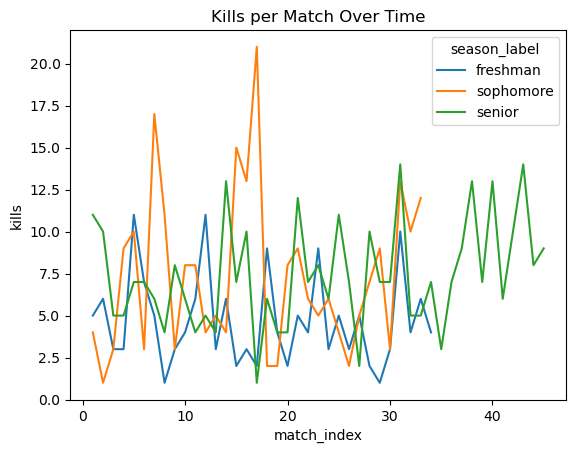

In [94]:
# K/M over time
sns.lineplot(data=df, x='match_index', y='kills', hue='season_label')
plt.title("Kills per Match Over Time")
plt.show()